<div id="container" style="position:relative;">
<div style="float:left"><h1> Data Prep and Exploration</h1></div>
<div style="position:relative; float:right">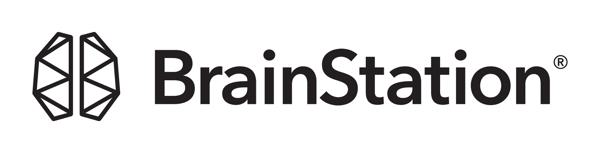
</div>
</div>



Data preparation and exploratory data analysis (EDA) are two processes that go hand in hand.

Before we can carry out any real meaningful analysis using data we must always go through the process of making sure our dataset is clean and fit for purpose. We can then begin exploring the data itself to build initial intuition about the trends contained within the data that could help us answer further questions or guide us other downstream tasks such as modeling. 

In this codealong we will go through the process of preparing and exploring a new dataset. Our aim is to build comfort using Pandas to clean data and develop a framework we can use whenever we need to clean data.  

### Dataset

We will be using a real world bank marketing dataset. The dataset contains information about customers who were contacted as part of a telephone marketing campaign trying to get customers to sign up for a term deposit product. The dataset also contains information about whether the customer has been contacted as part of the current marketing campaign or had been as part of a previous campaign. 

#### Data Dictionary

To help us with our analysis, take some time to study the data dictionary below. 

Demographic & client data:
- age (numeric)
- job (categorical)
- marital: marital status (categorical, note: 'divorced' means divorced or widowed)
- education (categorical)
- credit_in_default: has credit in default? (categorical)
- housing_loan: has housing loan? (categorical)
- personal_loan: has personal loan? (categorical)

Data about the calls from *this* campaign:
- last_contact_type: contact communication type (categorical)
- last_contact_month: last contact month of year (categorical)
- last_contact_day: last contact day of the week (categorical)
- last_contact_duration: last contact duration, in seconds (numeric)
- last_contact_duration_mins: last contact duration, in minutes (numeric)
- n_contacts_this_campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Data about calls from *previous* campaigns:
- n_contacts_prev_campaign: number of contacts performed before this campaign and for this client (numeric)
- prev_campaign_outcome: outcome of the previous marketing campaign (categorical)

Field of interest:
- registered: has the client registered for a term deposit?

### Question of interest

Imagine we work as a data analyst/scientist within the marketing department of the bank which owns this data. Our manger asks us to investigate the following: 

> How do customers who registered for the term deposit product differ from those who did not? This can be in terms of customer demographics or in terms of features of the current and prior marketing campaign. 


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [32]:
bank_df = pd.read_csv('bank-marketing-data.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: 'bank-marketing-data.csv'

In [34]:
bank_df.head()

NameError: name 'bank_df' is not defined

In [ ]:
bank_df.shape
print(f'We have {bank_df.shape[0]} rows and {bank_df.shape[1]} columns')

### Data Cleaning

The bank has provided us with this snapshot of demographic and campaign data related to the term deposit product. First, let's read in the data and take a look at what we're working with, and assess the level of cleaning and preprocessing that needs to be done.

In [ ]:
bank_df.info()

Most columns are of data type 'object' which means that pandas is treating them as non-numeric. We can see that most of them are categorical. We have some formatting issues with the 'job' column, which contains both job and location info. We should aim for a column to contain 1 type of information. 

#### Fixing the job column: 

In [ ]:
bank_df['job'].str.split(' - ')

In [ ]:
bank_df['job']

In [ ]:
#bank_df['job'].str.split(' - ', expand=True)

In [ ]:
bank_df.head()

In [ ]:
cols = bank_df['job'].str.split(' - ', expand=True)
bank_df['job'] = cols[0]
bank_df['location'] = cols[1]

bank_df.head()

We have resolved our formatting issues in our dataset. We will move on with other steps:

In [ ]:
bank_df['education'] = 1
bank_df.drop(['Unnamed: 0','notexist'], axis=1, inplace=True)

In [ ]:
bank_df.head()

### Deal with duplicate values

When dealing with duplicates, we want to make sure that we remove duplicate rows and columns: 

In [ ]:
# use .duplicated() to check for duplicates 

print(bank_df.duplicated().sum())

# get the proportion of the rows that are duplicates
print(bank_df.duplicated().mean())

We have 51 duplicate rows, which make up about 0.4% of our total dataset. Let's look into these in more detail: 

In [ ]:
bank_df[bank_df.duplicated(keep=False)].head()

In [ ]:
# Let's sort by age to force duplicate rows to appear close to each other 
bank_df[bank_df.duplicated(keep=False)].sort_values('age').head()

There is no unique identifier, so there is a chance that these are in fact unique customers who share all the same information. However, this is highly unlikely, we can assume that we can refer to these rows as duplicates. 

In [ ]:
bank_df = bank_df.drop_duplicates()

In [ ]:
bank_df.duplicated().sum()

In [ ]:
bank_df.T.duplicated()

No duplicated columns in terms of identical data, but what about redundant data? At first glance, the columns seem to be recording different information. 

In [ ]:
bank_df.info()

### Null Values:

In [ ]:
bank_df.isna()

In [ ]:
# return the number of nulls per column 
display(bank_df.isna().sum())

print(' ')

# return the proportion of each column that is null
display(bank_df.isna().mean())

Our aim is to clean all the null values. Let's start with numeric columns. 

#### Age: -- Numeric

Only ~4.99% of our data is missing the age column. The method we chose will not cause too much bias/skew given the small percentage. 

In [ ]:
# plot the distribution of age 

plt.figure()
plt.hist(bank_df['age'], bins=30)
plt.title('Distribution of age column')
plt.xlabel('Age')
plt.ylabel('Frequency')

# plot the mean and median
plt.axvline(bank_df['age'].mean(), c='red', label='mean')
plt.axvline(bank_df['age'].median(), c='orange', label='median')

plt.legend()
plt.show()

We see a positive skew in the data. The majority of the customer-base is below the age of 40. The mean is pulled towards the older ages and away from the majority of the data. In this case we could argue that the median is a better measure of central tendency. So we will use the median to impute null values for this column. 

In [ ]:
# imputing the nulls with the .median()
bank_df['age'] = bank_df['age'].fillna(bank_df['age'].median())

bank_df['age'].isna().sum()

#### Last Contact Duration -- Numeric 

This column has a much higher porportion of null values (~24.5%) than the other ones we've looked so far. Our choice of how to deal with these nulls will have a material impact on our data. 

In [ ]:
plt.figure()
plt.hist(bank_df['last_contact_duration'], bins=40)
plt.axvline(bank_df['last_contact_duration'].mean(), color='red', label='mean')
plt.axvline(bank_df['last_contact_duration'].median(), color='orange', label='median')
plt.legend()
plt.show()

We can see that there is a strong skew to this distribution so we would once again make the median the better option for imputing. 

In [ ]:
print('Summary of statistics prior to imputation', end='\n\n')
display(bank_df['last_contact_duration'].describe())

In [ ]:
#imputing the values with median for this column
bank_df['last_contact_duration'] = bank_df['last_contact_duration'].fillna(bank_df['last_contact_duration'].median())

In [ ]:
print('Summary of statistics after to imputation', end='\n\n')
display(bank_df['last_contact_duration'].describe())

In [ ]:
plt.figure()
plt.hist(bank_df['last_contact_duration'], bins=40)
plt.axvline(bank_df['last_contact_duration'].mean(), color='red', label='mean')
plt.axvline(bank_df['last_contact_duration'].median(), color='orange', label='median')
plt.legend()
plt.show()

We can see that the new histogram has a very high peak in the bucket that contains the median. There has also been a large decrease int he standard deviation of the columns as many values are now the same. 

#### Job: -- Categorical

In [ ]:
bank_df['job'].value_counts().plot(kind='barh')
plt.show()

display(bank_df['job'].value_counts())

We already have an unknown category. Given the small percentage of rows missing, we can just asign these nulls into the 'unknown' category. 

In [ ]:
bank_df['job'] = bank_df['job'].fillna('unknown')

#### Location: -- categorical

Let's look at location. One point to note is that the null values in this column would likely match up with the null values in the original job column we split this from. 

Once again this is categorical so we can either go with modal city or just apply unknown. 

In [ ]:
bank_df['location'].value_counts().plot(kind='barh')
plt.show()

display(bank_df['location'].value_counts().head(10))

Given that no one city froms the vast majority of lcoations, it will probably be better to assign the null values as 'unknown'

In [ ]:
bank_df['location'] = bank_df['location'].fillna('unknown')

In [ ]:
bank_df['location'].isna().sum()

We did it! We have located and replaced all the nulls and missing values in our dataset. 

### Exploratory Data Analysis (EDA)
Now that we've cleaned the data, let's do some analysis to address our original question: "What are the characteristics of the customers who register for the term deposit account?"

We will divide our data into categorical and numeric and proceed in this way.

In [40]:
bank_df.dtypes[bank_df.dtypes.values != 'object'].index.tolist()
num_cols = bank_df.dtypes[bank_df.dtypes.values != 'object'].index.tolist()

NameError: name 'bank_df' is not defined

In [36]:
len(num_cols)

NameError: name 'num_cols' is not defined

### Findings Summary

let's summarize what we've found from our initial analysis:

### Saving the data

Now that we have spent the time cleaning and exploring this dataset. We are going to save it down to file for now. In a short while, we will be using our cleaned dataset to carry out some modeling work to learn more about the customer characteristics which drive product registration! To be continued.... 

<div id="container" style="position:relative;">
<div style="position:relative; float:right">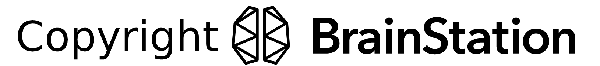
</div>
</div>